CarpetX-based vs. Carpet-based code: structure and syntax
=================================================
This notebook provides a thoroughly commented version of a piece of source code from **AsterX**, the new GR(M)HD code built upon CarpetX, and highlights the main differences in structure and syntax between CarpetX-based and Carpet-based code.

Primitives-to-conservatives conversion: basics
-------------------------------------------------------------------
The C++ code presented here comes from
```
AsterX/src/prim2con.cxx
```

and its purpose is to perform the initial **primitives-to-conservatives** conversion before the GRMHD evolution begins. In order to understand what this means, recall that the GRMHD equations are usually cast in *flux-conservative* form before a numerical solution to them is attempted (see, e.g., Jay Kalinani's talk about the Spritz code). The reason for that lies in the *Lax-Wendroff theorem*, which essentially states that if the numerical solution to an hyperbolic PDE cast in flux-conservative form converges to some function $f$ with increasing spatial grid resolution, then $f$ is a weak solution to the PDE at hand.


As an example, the conservation of the rest-mass density $\rho$ in flux-conservative form on a curved spacetime reads

$$
\partial_t\left(\sqrt{\det\!\left(\gamma\right)}\,D\right) + \partial_j\left(\sqrt{\det\!\left(\gamma\right)}\,D\widetilde{v}^j\right) = 0\;,
$$

where

$$
\begin{align}
    D               &= \rho W\\
    \widetilde{v}^j &= \frac{u^j}{u^0} = \alpha v^j - \beta^j
\end{align}
$$

with $W$ the Lorentz factor, $u$ the fluid's 4-velocity, $v$ the fluid's 3-velocity ("Valencia velocity"), $\alpha$ the lapse and $\beta$ the shift vector. In this context, $\rho$ is called the **primitive** variable, while $D = \rho W$ is the **conservative** variable associated to it; $\rho$ is the quantity we are actually interested in, while $D$ is the one we are going to evolve in time within our numerical method.


For the sake of compactness, the the full set of GRMHD equations in conservation form and the definitions of all conservative variables are not reported here (again see, e.g., Jay Kalinani's talk about the Spritz code). We will just list the names of all the primitive and conservative variables used in AsterX:

| **Primitive variable** | **Description**                   |
| ---------------------- | --------------------------------  |
| `rho`                  | Rest-mass density                 |
| `press`                | Pressure                          |
| `eps`                  | Specific internal energy          |
| `vel`                  | Fluid's 3-velocity (3 components) |

| **Conservative variable** | **Description**                   |
| ------------------------- | --------------------------------- |
| `dens`                    | Conserved rest-mass density       |
| `tau`                     | Conserved internal energy         |
| `mom`                     | Conserved momentum (3 components) |


Initialization
-----------------
First, include all the needed headers. `cctk.h`, `cctk_Arguments.h` and `cctk_Parameters.h` are the usual Cactus headers, while:
- `prim2con.hxx` defines some structs and a routine to perform the primitives-to-conservatives operation;
- `fixmath.hxx` lies in `Arith/src` and provides fixes to a few broken math operations defined in `cctk.h`. This should not be required anymore in the newest version of CarpetX but, in case it is needed, it should be included **BEFORE** any Cactus header file (i.e., the `cctk_<whatever>` files);
- `loop_device.hxx` lies in `CarpetX/src` and contains the infrastructure needed to perform loops on a GPU.

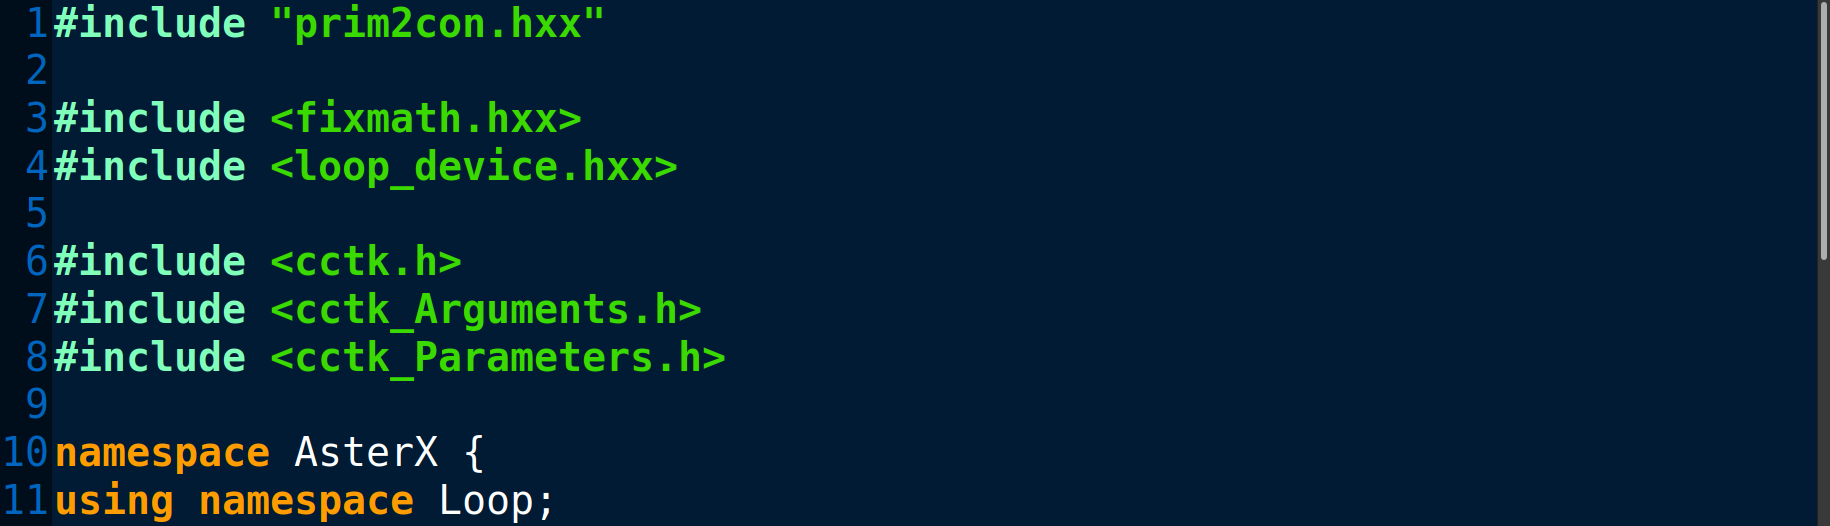

Now declare the scheduled function `AsterX_Prim2Con_Initial`, which performs the first primitives-to-conservatives conversion in order to begin the time evolution:

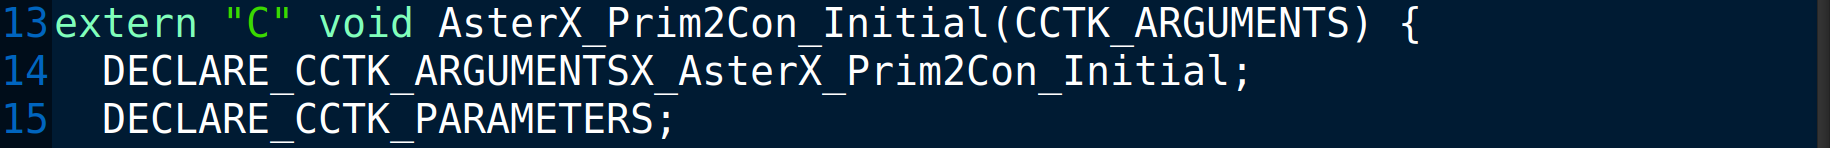

With Carpet, you would have
```
DECLARE_CCTK_ARGUMENTS_CHECKED(AsterX_Prim2Con_Initial);
```
In particular, watch out for the "X" in `ARGUMENTSX` in the CarpetX version of the macro!

Point descriptor
-----------------------
CarpetX provides the **point descriptor** as a very convenient way of accessing the value of any grid function at some given point:

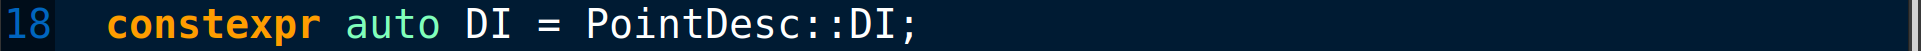

The `PointDesc` struct is defined in `CarpetX/src/loop.hxx`, which is included by `CarpetX/src/loop_device.hxx`, and looks like this:
```
struct PointDesc {
  int imin, imax;
  int i, j, k;
  CCTK_REAL x, y, z;
  CCTK_REAL dx, dy, dz;
  int idx;
  static constexpr int di = 1;
  int dj; // stride in the j direction
  int dk; // stride in the k direction
  int np; // number of grid points
  vect<int, dim> I;
  vect<int, dim> NI; // outward boundary normal, or zero
  vect<int, dim> I0; // nearest interior point
  static constexpr vect<vect<int, dim>, dim> DI = {vect<int, dim>::unit(0),
                                                   vect<int, dim>::unit(1),
                                                   vect<int, dim>::unit(2)};
  vect<CCTK_REAL, dim> X;
  vect<CCTK_REAL, dim> DX;
  
  <An operator to describe this struct if desired>
};
```

In particular, `PointDesc::DI` is essentially a vector consisting of the three unit vectors (1, 0, 0), (0, 1, 0), (0, 0, 1). The template struct `vect` and its attribute `unit` are defined in `Arith/src/vect.hxx`, which is included by `CarpetX/src/loop.hxx`.

Looping on the GPU
-----------------------------
As you may recall from the CUDA examples we saw before, a GPU cannot be used directly to run code; rather, we need a CPU (the _'host'_) to dump the workload to the GPU (the _'device'_) when desired. In CUDA, whose syntax is basically that of C++, this is accomplished by qualifying a function with the keyword `__global__` to tell the compiler — **NVCC** — that the given function must be run on the GPU(s); this simple tweak turns a standard C++ function into a GPU _kernel_.

However, the full story is not so simple. In a nutshell, we need to:
1. manually allocate memory for all the needed variables on the host (via `malloc` or similar);
2. manually allocate memory for the copies of the above variables to be passed to the device (via `cudaMalloc` or similar);
3. manually copy the variables from the host to the device (via `cudaMemcpy` or similar);
4. call the function to be executed on the device, i.e. _'launch the kernel'_. Notice that the number of blocks and the number of parallel threads per block the kernel should run on have to be specified manually;
5. manually transfer the processed data from the device back to the host;
6. manually free the allocated memory on the host;
7. manually free the allocated memory on the device.

This rapidly gets clumsy and error-prone as the code gets bigger and more articulated; for this reason, by means of the AMReX infrastructure, CarpetX provides the user with useful, easy-to-use wrappers around the CUDA framework. By far one of the most helpful among such wrappers is the one used to launch a kernel performing **loops** on a GPU — a simple `for` loop won't work on the device.

The cell below shows how to set up a device loop over the interior of the whole physical domain of our simulation within CarpetX:

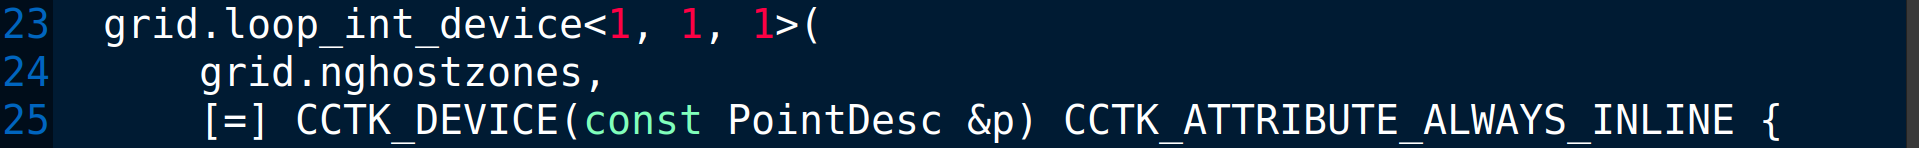

There are a few points worth noting:
1. **VERY IMPORTANT:** on a regular CPU machine, the **same** piece of code performs (multithreaded) loops on a CPU. This means we don't need to write different codes to run on a CPUs or on GPUs;
2. `grid` is a `GridDescBaseDevice` object, where the latter is a struct defined in `CarpetX/src/loop_device.hxx`. Here, however, `grid` is declared inside the `DECLARE_CCTK_ARGUMENTSX_AsterX_Prim2Con_Initial` macro, which also includes the declarations of the grid functions needed by this routine;
3. the method `loop_int_device` from `GridDescBaseDevice` is used to loop over all interior grid points. Similar methods are defined inside `GridDescBaseDevice` to loop over different regions of the domain:
  - `loop_all_device`: loop over all points
  - `loop_bnd_device`: loop over all outer boundary points excluding ghost faces, but including ghost edges and corners of non-ghost faces
4. `<1, 1, 1>` means the loop is performed over _cell centers_; `<0, 0, 0>` would mean looping over cell vertices; `<1, 0, 0>`, `<0, 1, 0>` or `<0, 0, 1>` would mean looping over cell edges; and `<1, 1, 0>`, `<1, 0, 1>` or `<0, 1, 1>` would mean looping over cell faces;
5. `loop_int_device` takes two arguments: `grid.nghostzones` and the C++ lambda
```
[=] CCTK_DEVICE(const PointDesc &p) CCTK_ATTRIBUTE_ALWAYS_INLINE {<lambda body>}
```
Notice that:
  - the lambda captures variables _by value_ (`[=]`): this is related to _copying_ variables from the host to the device. However, even when this code is run on a CPU, we need to capture variables by value and not by reference in order for multithreading to work properly (otherwise multiple threads would write on the same memory area at the same time);
  - the lambda is called _from the device_ to run on the device itself. From `CarpetX/src/loop.hxx`,
```
#define CCTK_DEVICE __device__
```
where `__device__` is the CUDA keyword that identifies functions which are supposed to be called from the device and run on it;
  - `const PointDesc &p` is a parameter passed to the lambda;
  - `CCTK_ATTRIBUTE_ALWAYS_INLINE` tells the compiler to inline the body of the lambda.

Body of the loop (i.e., body of the lambda)
------------------------------------------------------------
The goal here is to average all the six components of the spacetime metric from the vertices of each cell to the center of the same cell for all cells inside the numerical domain; the cell-averaged metric will then be used to perform the primitives-to-conservatives operation.

First, for a given cell, declare a `metric`-type object `g` and initialize all its components to zero. The `metric` struct is defined in `AsterX/src/prim2con.hxx` and looks like this:
```
struct metric {
  CCTK_REAL gxx, gxy, gxz, gyy, gyz, gzz;
};
```

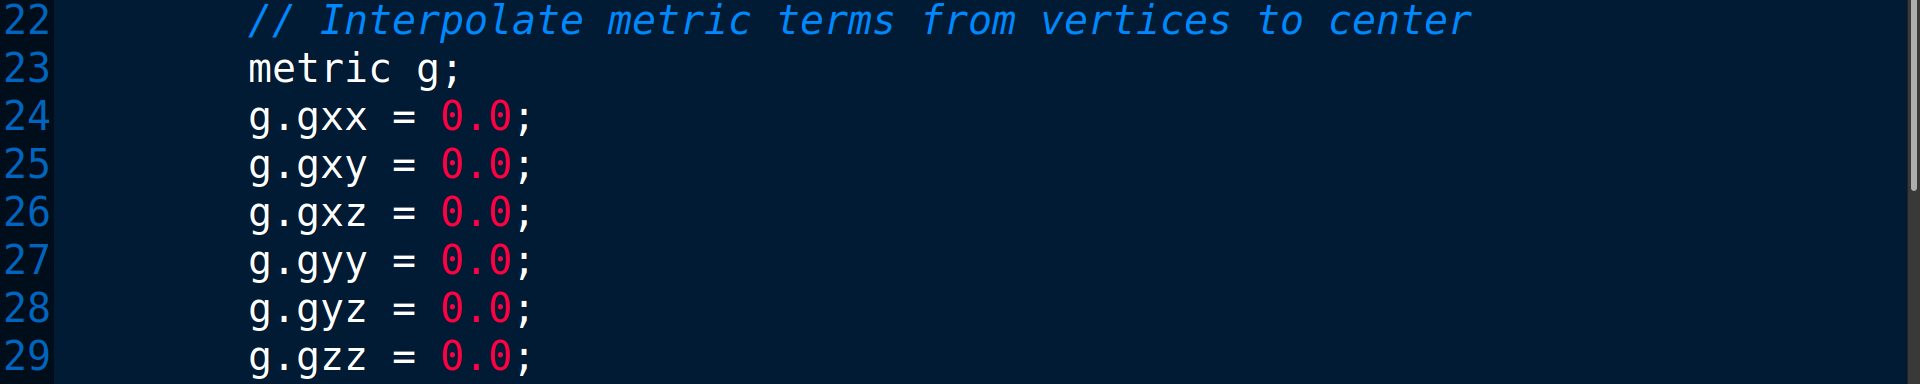

Next, take cell-averages of all metric components:

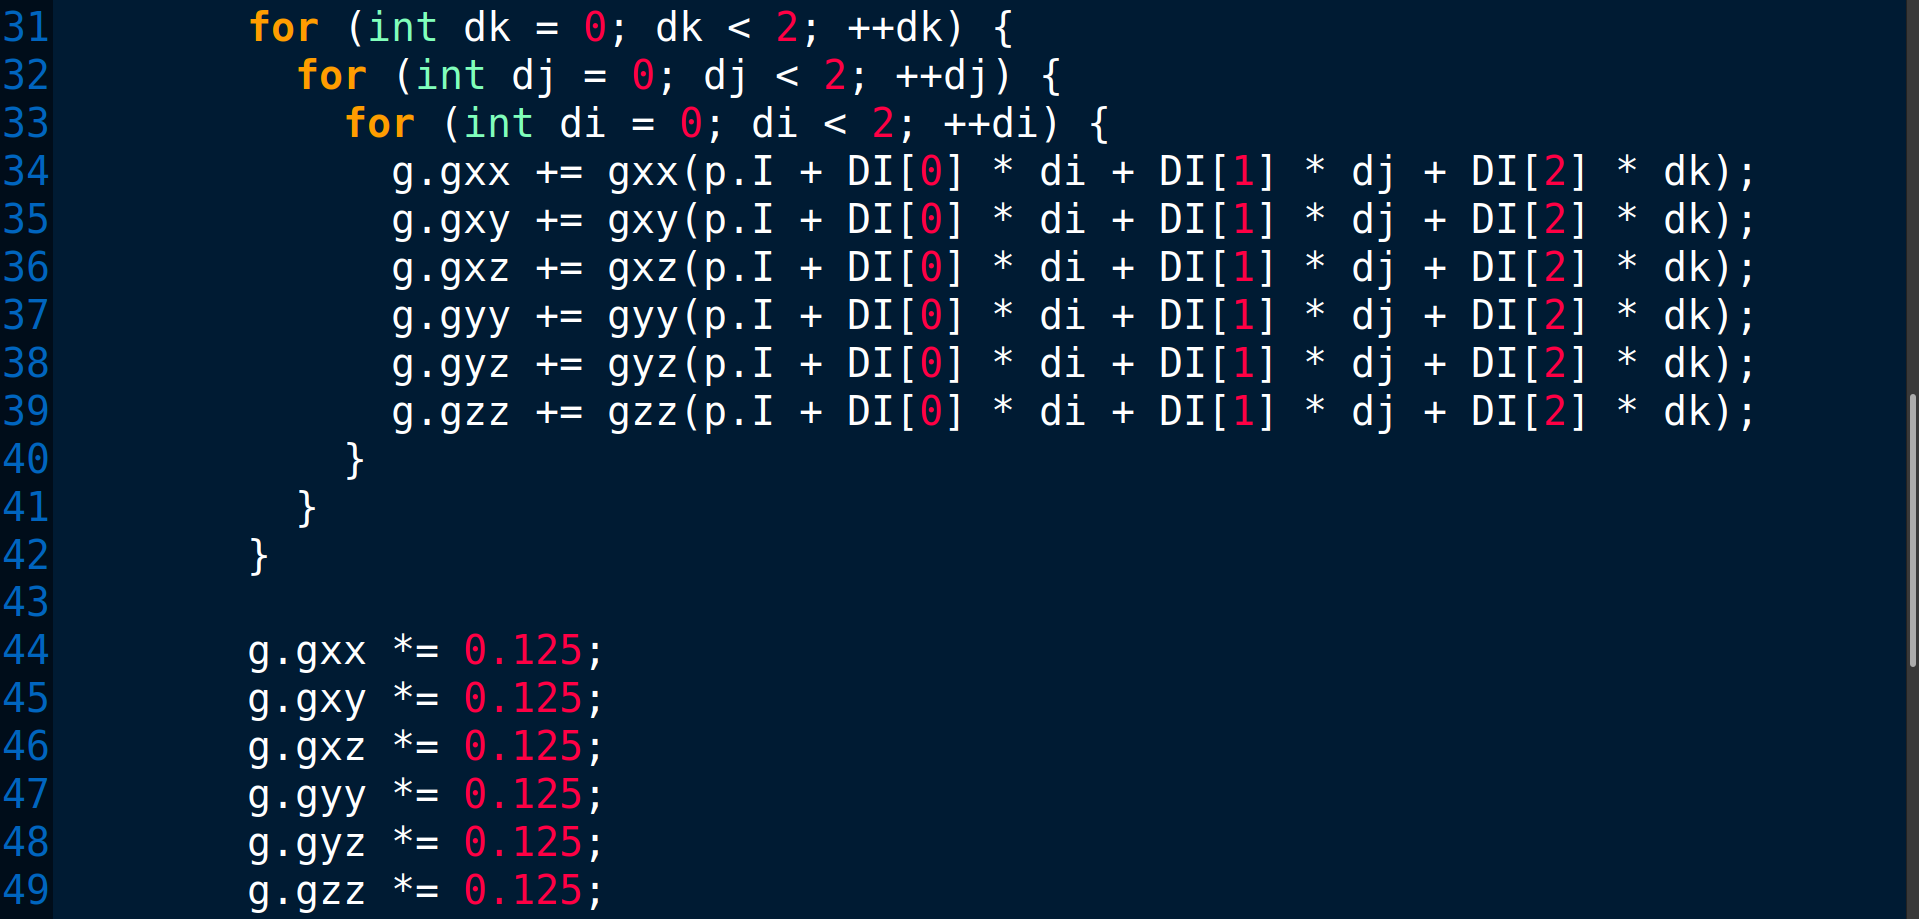

Here, on the RHS of each expression inside the nested `for` loop, `gxx`, `gxy`, `gxz`, `gyy`, `gyz` and `gzz` are _vertex-centered_ grid functions. Therefore, `p.I` gives the index of a _vertex_ (to be precise, the *top-left* vertex) of the current cell and the expression
```
DI[0] * di + DI[1] * dj + DI[2] * dk
```
selects one of the other vertices depending on the values of `di`, `dj` and `dz` (either 0 or 1).

**NOTE:** ideally, in the above device loop, we would like to use `p.DI` instead of declaring (see section "Point descriptor")
```
constexpr auto DI = PointDesc::DI;
```

and then use `DI` in the loop. Unfortunately, accessing `p.DI` on the device is not permitted by the compiler.

Finally, compute the conservative variables from the primitives:

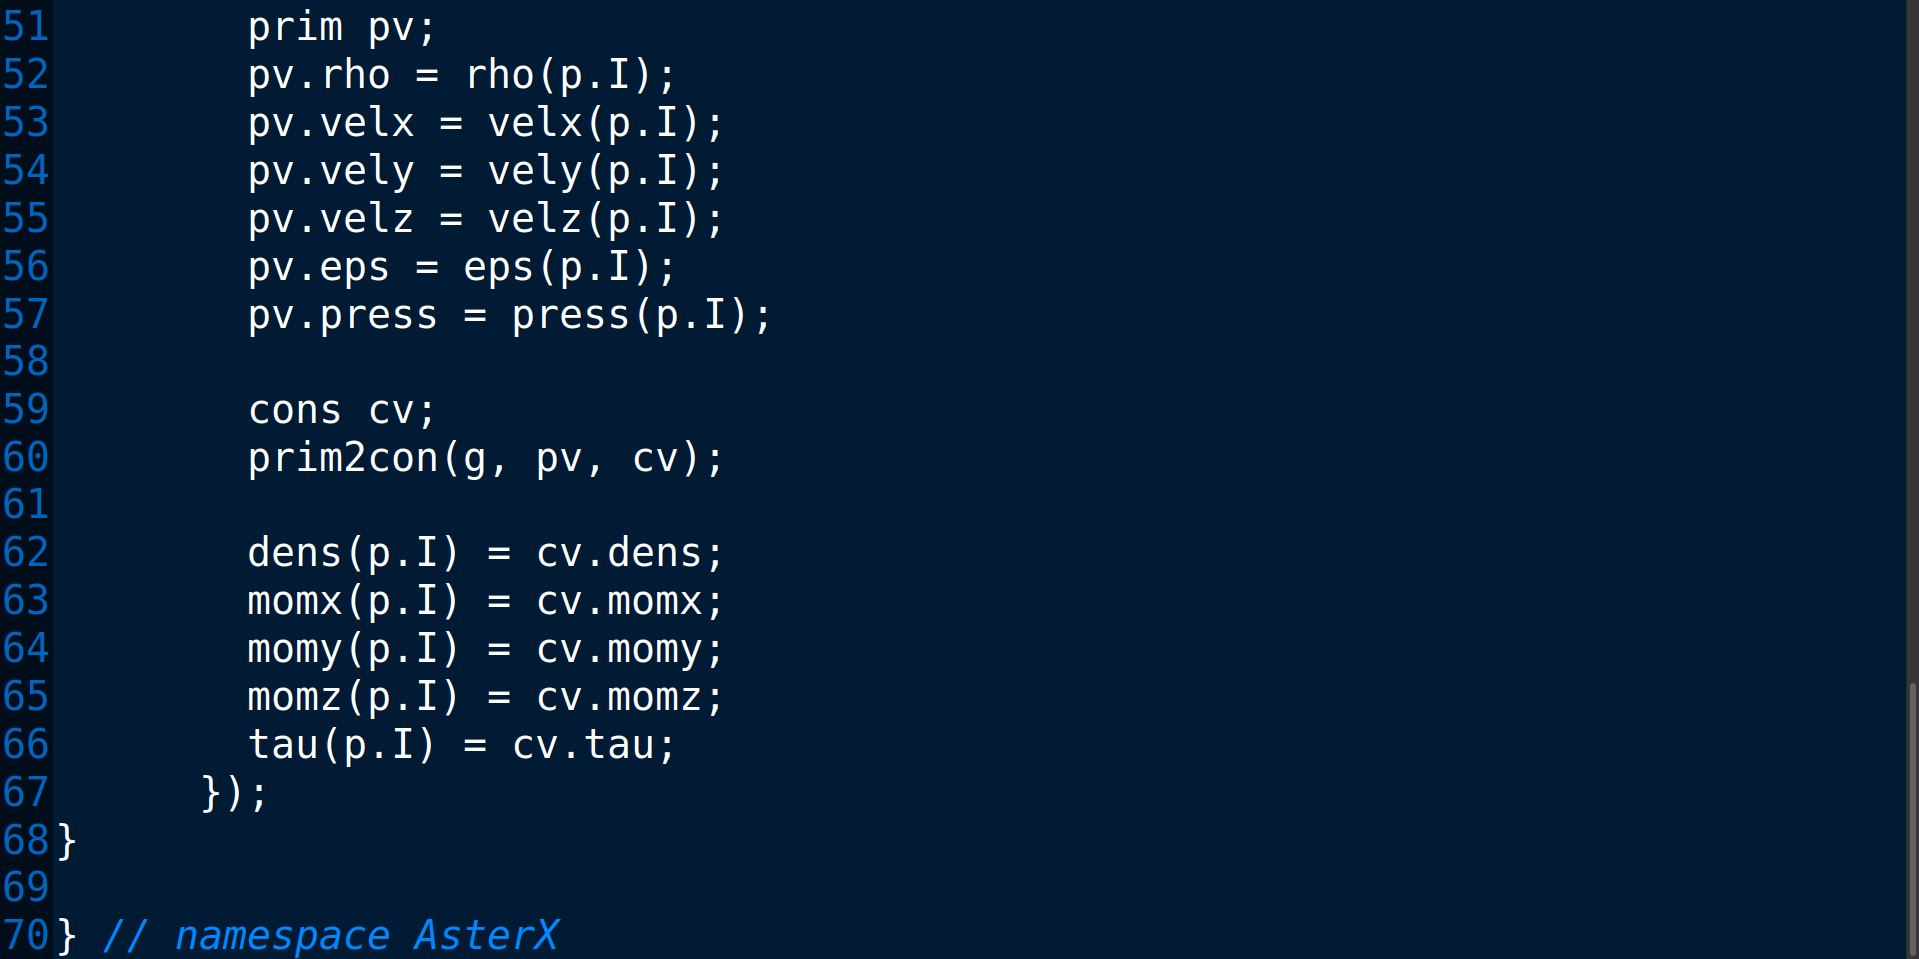

The structs `prim` and `cons` are defined in `AsterX/src/prim2con.hxx` and look like this:
```
struct prim {
  CCTK_REAL rho;
  CCTK_REAL velx, vely, velz;
  CCTK_REAL eps, press;
};

struct cons {
  CCTK_REAL dens;
  CCTK_REAL momx, momy, momz;
  CCTK_REAL tau;
};
```
The `prim2con` routine, which performs the actual conservatives-to-primitives operation, is also defined in the same header.

Comparison with Carpet
-----------------------------------
As we have just seen, the way of accessing grid function values has changed considerably with CarpetX compared to Carpet. In Carpet, the above loop would look something like:
```
struct metric {
  CCTK_REAL gxx, gxy, gxz, gyy, gyz, gzz;
};

for (int k = 0; k < cctk_lsh[2]; ++k) {
  for (int j = 0; j < cctk_lsh[1]; ++j) {
    for (int i = 0; i < cctk_lsh[0]; ++i) {
      metric g;
      g.gxx = 0.0;
      g.gxy = 0.0;
      g.gxz = 0.0;
      g.gyy = 0.0;
      g.gyz = 0.0;
      g.gzz = 0.0;

      const int ijk       = CCTK_GFINDEX3D(cctkGH, i,   j,   k);
      const int ip1jk     = CCTK_GFINDEX3D(cctkGH, i+1, j,   k);
      const int ijp1k     = CCTK_GFINDEX3D(cctkGH, i,   j+1, k);
      const int ijkp1     = CCTK_GFINDEX3D(cctkGH, i,   j,   k+1);
      const int ip1jp1k   = CCTK_GFINDEX3D(cctkGH, i+1, j+1, k);
      const int ip1jkp1   = CCTK_GFINDEX3D(cctkGH, i+1, j,   k+1);
      const int ijp1kp1   = CCTK_GFINDEX3D(cctkGH, i,   j+1, k+1);
      const int ip1jp1kp1 = CCTK_GFINDEX3D(cctkGH, i+1, j+1, k+1);
 
      g.gxx += gxx[ijk]     + gxx[ip1jk]   + gxx[ijp1k]   + gxx[ijkp1]
             + gxx[ip1jp1k] + gxx[ip1jkp1] + gxx[ijp1kp1] + gxx[ip1jp1kp1];
      g.gxy += gxy[ijk]     + gxy[ip1jk]   + gxy[ijp1k]   + gxy[ijkp1]
             + gxy[ip1jp1k] + gxy[ip1jkp1] + gxy[ijp1kp1] + gxy[ip1jp1kp1];
      g.gxz += gxz[ijk]     + gxz[ip1jk]   + gxz[ijp1k]   + gxz[ijkp1]
             + gxz[ip1jp1k] + gxz[ip1jkp1] + gxz[ijp1kp1] + gxz[ip1jp1kp1];
      g.gyy += gyy[ijk]     + gyy[ip1jk]   + gyy[ijp1k]   + gyy[ijkp1]
             + gyy[ip1jp1k] + gyy[ip1jkp1] + gyy[ijp1kp1] + gyy[ip1jp1kp1];
      g.gyz += gyz[ijk]     + gyz[ip1jk]   + gyz[ijp1k]   + gyz[ijkp1]
             + gyz[ip1jp1k] + gyz[ip1jkp1] + gyz[ijp1kp1] + gyz[ip1jp1kp1];
      g.gzz += gzz[ijk]     + gzz[ip1jk]   + gzz[ijp1k]   + gzz[ijkp1]
             + gzz[ip1jp1k] + gzz[ip1jkp1] + gzz[ijp1kp1] + gzz[ip1jp1kp1];

      g.gxx *= 0.125;
      g.gxy *= 0.125;
      g.gxz *= 0.125;
      g.gyy *= 0.125;
      g.gyz *= 0.125;
      g.gzz *= 0.125;

      // Use g.gxx, g.gxy, g.gxz, g.gyy, g.gyz, g.gzz in some way
      do_something(g.gxx, g.gxy, g.gxz, g.gyy, g.gyz, g.gzz);
    }
  }
}
```

Appendix: scheduling CarpetX-based routines
======================================
The structure of a CarpetX-based thorn isn't any different from that of Carpet-based ones, except we **MUST** explicitly declare which grid functions are read and/or written by each scheduled routine via `READS` and `WRITES` statements; the only exception to this rule occurs if the routine at hand does not read nor write any grid functions. `READS` and `WRITES` statements are also accepted — but NOT mandated — by Carpet; it is however advisable to always include them in order to write clean and correct Carpet-based code.

As an example, the routine `AsterX_Prim2Con_Initial` above is scheduled in `AsterX/schedule.ccl` as:
```
SCHEDULE AsterX_Prim2Con_Initial AT initial AFTER HydroBase_PostInitial
{
  LANG: C
  READS: ADMBase::metric(interior)
  READS: HydroBase::rho(interior) HydroBase::vel(interior) HydroBase::eps(interior) HydroBase::press(interior)
  WRITES: dens(interior) tau(interior) mom(interior)
  SYNC: dens tau mom
} "Compute conserved variables from primitive variables at initial"

```